# Example In Situ Sequencing Data
Here is a small example on how to run ISTDECO on an In Situ Sequencing dataset from [1]. (References are in the end of the notebook).

## Set path variables
The data and codebook can be downloaded from [2].

In [1]:
# Where to load the images and codebook from
data_path = r'F:\BIIFProjects\MariaUlvmar2021-1\data\MU\shared' 

# Where to save .csv with results
csv_save_path = data_path + r'\results.csv'

## Load the data

In [7]:
import csv
import numpy as np

def loadCodebook (csvFilename):
    with open(csvFilename, 'r') as csvFile:
        csvData = list(csv.reader(csvFile))
    print (csvData)
    target_names = np.array([line[1] for line in csvData])
    target_letters = np.array([line[0] for line in csvData])
    def oneHotEncode (tag):
        letters = ['A', 'C', 'G', 'T']
        return [
            [int(l1 == letter) for l1 in letters]
            for letter in tag
        ]
    codebook = np.array([
        oneHotEncode(line[0]) for line in csvData
    ])
    return {"codebook":codebook, "target_names":target_names, "target_letters":target_letters}
csvFilename = f'{data_path}/codebook.csv'


In [3]:
temp = loadCodebook(f'{data_path}/codebook.csv')
codebook = temp['codebook']
target_names = temp['target_names']
codebook = codebook / codebook.sum(axis=(1,2), keepdims=True)

[['CGTCG', 'A2M'], ['TCCAC', 'ACKR1'], ['CACGG', 'ACTA2'], ['GCCGT', 'AGER'], ['TAACC', 'AIRE'], ['AGACC', 'ASCL1'], ['TCGCT', 'ASCL3'], ['GTCTT', 'BPIFB1'], ['CCCTA', 'CAV1'], ['GGACC', 'CD34'], ['ACTAC', 'CFTR'], ['GTTCG', 'CLDN5'], ['CTGAG', 'COL1A1'], ['TCTGC', 'COL1A2'], ['GCCTA', 'CYP2F1'], ['ATCTA', 'DES'], ['GATGT', 'EDN1'], ['ATGAC', 'EPCAM'], ['GCCCT', 'FBLN1'], ['TAAGG', 'FOXI1'], ['CAGTC', 'FOXJ1'], ['AAAGT', 'FOXN4'], ['CGTGT', 'GJA5'], ['CACAG', 'GSTA1'], ['TTAGA', 'INMT'], ['GAACC', 'KRT13'], ['CGGAG', 'KRT14'], ['TGTTA', 'KRT15'], ['TGTGA', 'KRT19'], ['CGGTA', 'KRT5'], ['CTTCG', 'LGR6'], ['AAGTC', 'LTF'], ['AAGCA', 'MSLN'], ['ACACT', 'MUC5AC'], ['TAATG', 'MUC5B'], ['GTTAG', 'PCSK1N'], ['GAGTC', 'PECAM1'], ['GACAA', 'PLIN2'], ['GCGAG', 'PPARG'], ['CCGAT', 'PTN'], ['ATGCG', 'PTPRC'], ['TGTAC', 'SCGB1A1'], ['CCGCT', 'SCGB3A2'], ['AGCAC', 'SEMA3A'], ['CCAGA', 'SFTA2'], ['ACCGA', 'SFTPC'], ['TATAC', 'TAGLN'], ['TCGTA', 'TP63'], ['GGCAC', 'TPPP3'], ['AGATG', 'TRPM5'], ['CTGGG

In [ ]:
from PIL import Image

rounds = 5
channels = 4 # A, C, G, T
tile_height, tile_width = 512, 512
ntile_y, ntile_x = 20, 20

data_shape = (rounds, channels, ntile_y*tile_height, ntile_x*tile_width)
image_data = np.zeros(data_shape, dtype='float32')

channels = ['A', 'C', 'G', 'T']
# Load images and tile
for r in range(rounds):
    print ("Loading round {r}".format(r=r+1))
    for c in range(len(channels)):
        print (r,c)
        filepath = f'{data_path}/Round{r+1}/{channels[c]}.tif'
        im = np.array(Image.open(filepath), dtype='float32')
        pad_x, pad_y = ntile_x*tile_width-im.shape[0], ntile_y*tile_height-im.shape[1]
        im = np.pad(im, [(0,pad_x),(0,pad_y)], 'constant', constant_values=0)
        image_data[r,c] = im   

# Load gene names and codebook
temp = loadCodebook(f'{data_path}/codebook.csv')
codebook = temp['codebook']
target_names = temp['target_names']
target_letters = temp['target_letters']
codebook = codebook / codebook.sum(axis=(1,2), keepdims=True)

We need to set appropriate variables before we can run ISTDECO.

#### Notation
- $r$ Number of imaging rounds
- $c$ Number of channels
- $m$ Number of codes in codebook
- $h$ Image height
- $w$ Image width
- $\sigma_{psf}$ Standard deviation of the Gaussians describing the spatial shape of the spots
- $Y \in \mathbb{R}_+^{r\times c \times h \times w}$ Image data
- $D \in \mathbb{R}_+^{m \times r\times c}$ Codebook (Combinatorial labels)
- $b \in \mathbb{R}_+^{m \times r\times c}$ Background

In [5]:
r = 5
c = 4
m = codebook.shape[0]
h = 512
w = 512
sigma_psf = 1.
D = codebook
Y = image_data

# The images are already pre-processed
# with a baseline removal, hence we 
# put the baseline to an small-nonzero
# number. Mainly to avoid divisions by
# zero in the algorithm.
b = 1e-5

# Standard deviation of the point-spread-function
psf_std = 1.

# Number of iterations
niter = 3

# Suppression radius
local_max_radius = 1

# We want to use GPU
device = 'cpu'

# The images are too large to fit all on the GPU at once,
# hence we need to tile the images.
tiles = [(tiley,tilex) for tiley in range(ntile_y) for tilex in range(ntile_x)]

## Decode dataset

In [6]:
from tqdm import tqdm
import pandas as pd
from istdeco import ISTDeco

results = pd.DataFrame()
tau = np.percentile(image_data,99)

# Loop over the tiles
for iy, ix in tqdm(tiles):
    
    # Slice the image
    sy = slice(iy*tile_height, (iy+1)*tile_height)
    sx = slice(ix*tile_width, (ix+1)*tile_width)
    
    # Pick a tile
    tile = image_data[:,:, sy, sx] 
    
    # Create the model
    model = ISTDeco(tile,codebook, (psf_std,psf_std), b=b).to(device)
    
    # Run for few iterations and pick out 
    # deconvolved images
    X, Q, _ = model.run(niter=niter)
    
    # Pick out barcodes.
    # 99th percentile might seem like a strict choice, but recall 
    # that the images are very sparse, especially X. 
    code_id, y, x = np.where(np.logical_and(X>tau,Q>0.5))
        
    intensity = X[code_id, y, x]
    quality = Q[code_id, y, x]
                                 
    # Store in dataframe
    df = pd.DataFrame(data={
            'x': x.astype('float') + ix*tile_width, 
            'y': y.astype('float') + iy*tile_height,
            'target_id': code_id + 1, # Add a one here so id match with the benchmark
            'intensity': intensity, 
            'quality': quality,
            'target_name': target_names[code_id],
            'target_letters': target_letters[code_id]
    })
                                 
    results = results.append(df)

results.to_csv(csv_save_path)

  4%|▍         | 18/400 [01:09<24:37,  3.87s/it]C:\Users\chrav452\AppData\Local\Temp/ipykernel_10260/4290453298.py:28: RuntimeWarning: invalid value encountered in greater
  code_id, y, x = np.where(np.logical_and(X>tau,Q>0.5))
100%|██████████| 400/400 [26:49<00:00,  4.02s/it]


# View in TissUUmaps

In [2]:
import os, json, csv

rounds = 5
channels = ['A', 'C', 'G', 'T']

#results.to_csv(csv_save_path)
with open(csv_save_path, "r") as f:
    csvData = list(csv.DictReader(f))
with open(csv_save_path.replace(".csv","_tmap.csv"), 'w', newline='') as csvfile:
    fieldnames = list(csvData[0].keys()) + ["channels","rounds"]
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    for line in csvData:
        line["quality"] = 2*(float(line["quality"]) - 3.)
        line["channels"] = ";".join([str("ACGT".index(l)) for l in line["target_letters"]])
        line["rounds"] = ";".join([str(r) for r in range(rounds)])
        writer.writerow(line)

def getJsonProject(markerFile, layers):
    return {
        "markerFiles": [
                    {
                        "path": markerFile,
                        "title": "Download markers","comment": "",
                        "expectedCSV": { 
                            "group": "target_letters", "name": "target_name", "X_col": "x", "Y_col": "y", "key": "letters","scale":"quality"
                        },
                        "autoLoad": True
                    }
                ], 
        "filters": ["Contrast","Color"],
        "compositeMode": "source-over",
        "layers": [
            {
                "tileSource": l + ".dzi",
                "name": "{round}_{channel}".format(round=os.path.dirname(l), channel=os.path.basename(l))
            } for l in layers
        ], 
        "filename": "",
        "plugins": ["Spot_Detection"],
        "settings": [
            {"module":"dataUtils","function":"_autoLoadCSV","value":True},
            {"module":"glUtils","function":"_globalMarkerScale","value":1},
            {"module": "markerUtils","function": "_startMarkersOn","value": True}
        ]
    }

layers = ["Round{r}/{c}.tif".format(r=r+1, c=c) for r in range(rounds) for c in channels + ["DAPI"]]
jsonProject = getJsonProject("results_tmap.csv", layers)
projectFile = "{dir}/project.tmap".format(dir=data_path)
with open(projectFile, "w") as f:
    json.dump(jsonProject, f)

In [5]:
import os
import sys
module_path = r"C:\Users\chrav452\Documents\GitHub\TissUUmaps\flask"
if module_path not in sys.path:
    sys.path.append(module_path)

from tissuumaps import jupyter as tj

tj.opentmap(projectFile)

In [4]:
viewer = tmapp.viewer("project.tmap")

# Plot results
In the codebook we added nine additional "fake", or "non-targeted" codes. We can use these codes to assess the quality of the decoded barcodes.

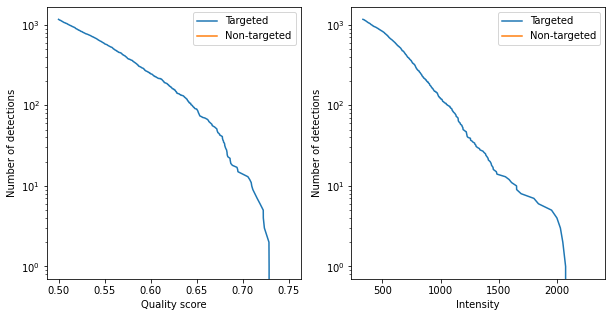

In [27]:
import matplotlib.pyplot as plt
# Name of nontargeted genes
non_targeted_names = [ f'blank-{i+1}' for i in range(9)]

# Load the raw decoding from the csv
results = pd.read_csv(csv_save_path)

# Split the dataframe into targeted and non targeted detections
ntargeted = results[results['target_name'].isin(non_targeted_names)]
targeted = results[~results['target_name'].isin(non_targeted_names)]

# Sort data by intensity and quality
ntargeted_quality = ntargeted.sort_values('quality',ascending=False)
ntargeted_intensity = ntargeted.sort_values('intensity',ascending=False)
targeted_quality = targeted.sort_values('quality',ascending=False)
targeted_intensity = targeted.sort_values('intensity',ascending=False)

# Plot curves
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.semilogy(targeted_quality['quality'].to_numpy(), \
             np.arange(0,targeted_quality.shape[0]), \
             label='Targeted')

plt.semilogy(ntargeted_quality['quality'].to_numpy(), \
             np.arange(0,ntargeted_quality.shape[0]), \
             label='Non-targeted')
plt.xlabel('Quality score')
plt.ylabel('Number of detections')
plt.legend()

plt.subplot(122)
plt.semilogy(targeted_intensity['intensity'].to_numpy(), \
             np.arange(0,targeted_quality.shape[0]), \
             label='Targeted')

plt.semilogy(ntargeted_intensity['intensity'].to_numpy(), \
             np.arange(0,ntargeted_quality.shape[0]), \
             label='Non-targeted')
plt.xlabel('Intensity')
plt.ylabel('Number of detections')
plt.legend()

From the above images we note that a quality threshold set to 0.6 seems to filter out many of the non-targeted detections while still keeping many the targeted detections. Let's use this threshold and check correlation with benchmark computed using pipeline in [1].

In [28]:
n_genes = 170
def count_targets(target_ids):
    return np.array([np.sum(target_ids == i+1) for i in range(n_genes)])
        
# Load benchmark genes
benchmark = pd.read_csv('benchmark/iss_benchmark.csv')
    
# remove barcodes near the border of the image
fov = [100,100,9215-200,5120-200]
results = results[ (results['x'] >= fov[0]) & (results['x'] <= fov[2])  & (results['y'] >= fov[1]) & (results['y'] <= fov[3])]
benchmark = benchmark[ (benchmark['x'] >= fov[0]) & (benchmark['x'] <= fov[2])  & (benchmark['y'] >= fov[1]) & (benchmark['y'] <= fov[3])]


# Filter detections such that less than n non targeted barcodes are detected
n = 10
threshold = ntargeted['quality'].nlargest(n).iloc[-1]
result_counts = count_targets(results[results['quality'] > threshold]['target_id'])

# Load the benchmark data and filter so that less than n non targeted barcodes are detected
threshold = benchmark[benchmark['is_non_targeted'] == 1]['quality'].nlargest(n).iloc[-1]
benchmark_counts = count_targets(benchmark[benchmark['quality'] > threshold]['target_id'])


# Plot the count of the different detected barcodes
tmp = np.vstack((result_counts, benchmark_counts)).T
r = np.corrcoef(tmp[:, 1], tmp[:, 0])[0, 1]
x = np.linspace(50, 25000)
f, ax = plt.subplots(figsize=(6, 6))
ax.scatter(tmp[:, 1], tmp[:, 0], 50, zorder=2)
ax.plot(x, x, '-k', zorder=1)

plt.xlabel('Benchmark barcode type counts')
plt.ylabel('ISTDECO barcode type counts')
plt.title(f'r = {r}')

IndexError: single positional indexer is out-of-bounds

In [10]:
import pandas as pd
import numpy as np
import umap

# Where to load the images and codebook from
data_path = r'F:\BIIFProjects\MariaUlvmar2021-1\data\MU\shared' 

# Where to save .csv with results
csv_save_path = data_path + r'\results.csv'

def rgb_to_hex(r, g, b):
  return ('#{:X}{:X}{:X}').format(r, g, b)

tile_height, tile_width = 512, 512
ntile_y, ntile_x = 20, 20

df = pd.DataFrame(csvData)
# Convert x and y columns to numeric
df["x"], df["y"] = pd.to_numeric(df["x"]), pd.to_numeric(df["y"])

# Remove TTTTT
df = df[df.target_name != "TTTTT"]

output_dict = []

for i in range(50,tile_width * ntile_x, 100):
    for j in range(50,tile_height * ntile_y, 100):
        df['dist'] = np.sqrt( (df.x-i)**2 + (df.y-j)**2)
        # ignore if not enough markers in close neighborhood 
        if len(df.loc[df['dist'] < 200]) <= 15 or len(df.loc[df['dist'] < 50]) <= 0:
            continue
        # Get all markers closer in a 300 pixels neighborhood
        point_dict = dict(df.loc[df['dist'] < 300]['target_id'].value_counts())
        # Keep x and y info
        point_dict["x"],point_dict["y"] = i, j
        output_dict.append(point_dict)

# Convert to dataframe and add missing 0
df_out_xy = pd.DataFrame(output_dict).fillna(0)

reducer = umap.UMAP(n_components=3)
df_out = df_out_xy.drop("x",axis=1)
df_out = df_out.drop("y",axis=1)

embedding = reducer.fit_transform(df_out)
embedding.shape
embedding = embedding-embedding.min(axis=0)
normalized_embedding=255*embedding/embedding.max(axis=0)
normalized_embedding = normalized_embedding.astype(int)
print (normalized_embedding.min(axis=0),normalized_embedding.max(axis=0))
n=0
final_output = []
for ((r,g,b),row) in zip(normalized_embedding, df_out_xy.to_dict(orient="records")):
    dictionary = {
        "x":row["x"],"y":row["y"],"r":r,"g":g,"b":b,"umap":rgb_to_hex(r, g, b),"barcode":"All"
    }
    final_output.append(dictionary)
    #break

final_df = pd.DataFrame(final_output)
final_df.to_csv(csv_save_path.replace(".csv","_umap_TTTTT.csv"))

[0 0 0] [254 255 255]


# References
[1] *Qian, Xiaoyan, et al. "Probabilistic cell typing enables fine mapping of closely related cell types in situ." Nature methods 17.1 (2020): 101-106.*

[2] Axel Andersson, Ferran Diego, Fred A. Hamprecht, & Carolina Wählby. (2021). In Situ Sequencing data used in "ISTDECO: In Situ Transcriptomics Decoding by Deconvolution" [Data set]. Zenodo. http://doi.org/10.5281/zenodo.4560687

F:\BIIFProjects\MariaUlvmar2021-1\data\MU
F:\BIIFProjects\MariaUlvmar2021-1\data\MU
